In [1]:
from itertools import accumulate

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

df = pd.read_csv('final_df.csv')
df.head()

,ID,Gender,OwnCar,OwnProperty,ChildrenCount,TotalIncome,IncomeType,EducationType,FamilyStatus,HousingType,WorkPhone,Phone,Email,FamilyMembers,Target,AccountLength,Age,EMPLOYED,YearsEmployed
0,5008804,1,1,1,0,427500.0,3.0,3.0,3.0,3.0,1,0,0,2,1,15,32.868596,1,12.435582
1,5008806,1,1,1,0,112500.0,3.0,1.0,4.0,5.0,0,0,0,2,0,29,58.793855,1,3.104789
2,5008808,0,0,1,0,270000.0,2.0,1.0,0.0,5.0,0,1,1,1,0,4,52.321439,1,8.353360
3,5008812,0,0,1,0,283500.0,1.0,3.0,1.0,5.0,0,0,0,1,0,20,61.504385,0,0.000000
4,5008815,1,1,1,0,270000.0,3.0,3.0,4.0,5.0,1,1,1,2,0,5,46.193999,1,2.105452


In [2]:
df.isna().sum()

ID               0
Gender           0
OwnCar           0
OwnProperty      0
ChildrenCount    0
TotalIncome      0
IncomeType       0
EducationType    0
FamilyStatus     0
HousingType      0
WorkPhone        0
Phone            0
Email            0
FamilyMembers    0
Target           0
AccountLength    0
Age              0
EMPLOYED         0
YearsEmployed    0
dtype: int64

The preprocessed dataset has no NA values
Let me check correlation matrix

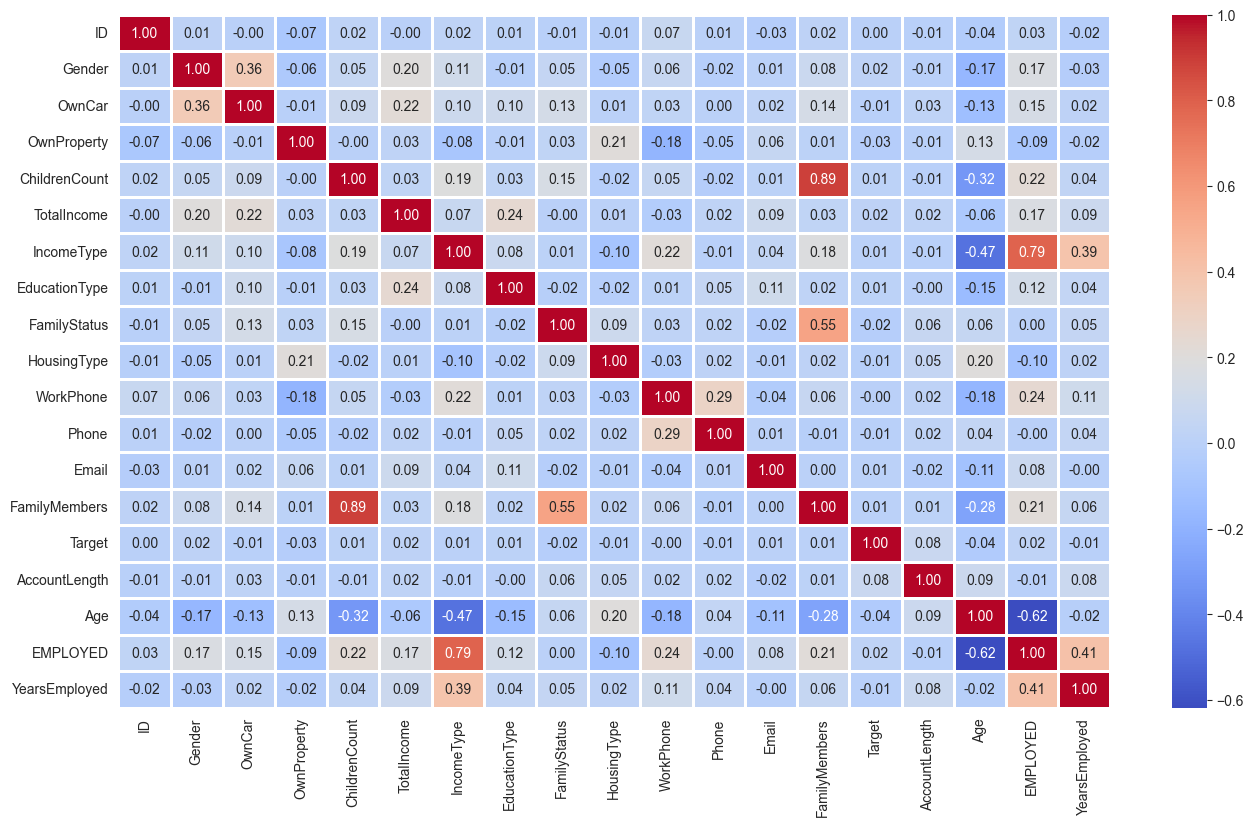

In [3]:
plt.figure(figsize=(16, 9))
sns.heatmap(data=df.corr(), annot=True, linewidths=1, fmt='.2f', cmap='coolwarm')
plt.show()

__let me check class imbalance__

<Axes: xlabel='Target', ylabel='count'>

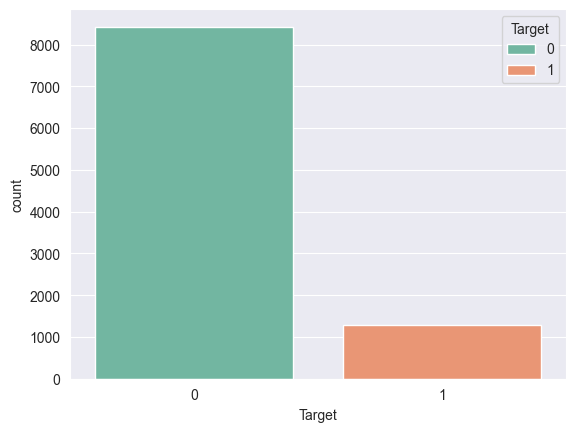

In [4]:
sns.countplot(x='Target', data=df, hue='Target', palette='Set2')

There is class imbalance so that SMOTE or any other possible techniques have to be used to balance the classes. 
Let's do this after splitting the dataset into train and test sets to avoid data leakage.

In [5]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['Target'], axis=1)
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6796, 18), (2913, 18), (6796,), (2913,))

In [6]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=69)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)

X_train_resampled.shape, y_train_resampled.shape

((11796, 18), (11796,))

In [7]:
y_train_resampled.value_counts()

Target
0    5898
1    5898
Name: count, dtype: int64

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold
import json

k_fold = KFold(n_splits=5, random_state=69, shuffle=True)

rf = RandomForestClassifier(random_state=69, n_jobs=-1)

param_grid = {
    'n_estimators': [25, 50],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=k_fold, n_jobs=-1, verbose=3, scoring='accuracy')

grid.fit(X_train_resampled, y_train_resampled)

print(f"best parameters: {grid.best_params_}")

y_pred = grid.predict(X_test)

print(f"accuracy on test set: {accuracy_score(y_test, y_pred)}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
best parameters: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
accuracy on test set: 0.8496395468589083


In [10]:
print("classification report:")
print(json.dumps(classification_report(y_test, y_pred, output_dict=True), indent=4))

classification report:
{
    "0": {
        "precision": 0.8716216216216216,
        "recall": 0.9695411392405063,
        "f1-score": 0.9179775280898876,
        "support": 2528.0
    },
    "1": {
        "precision": 0.2376237623762376,
        "recall": 0.06233766233766234,
        "f1-score": 0.09876543209876543,
        "support": 385.0
    },
    "accuracy": 0.8496395468589083,
    "macro avg": {
        "precision": 0.5546226919989297,
        "recall": 0.5159394007890843,
        "f1-score": 0.5083714800943265,
        "support": 2913.0
    },
    "weighted avg": {
        "precision": 0.7878285643578137,
        "recall": 0.8496395468589083,
        "f1-score": 0.8097054179091179,
        "support": 2913.0
    }
}


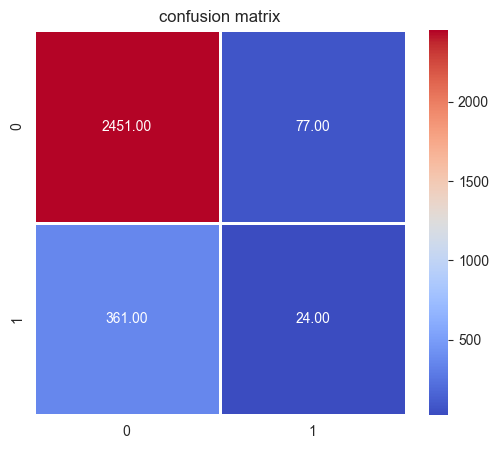

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, fmt='.2f', annot=True, cmap='coolwarm', linewidths=1)
plt.title("confusion matrix")
plt.show()

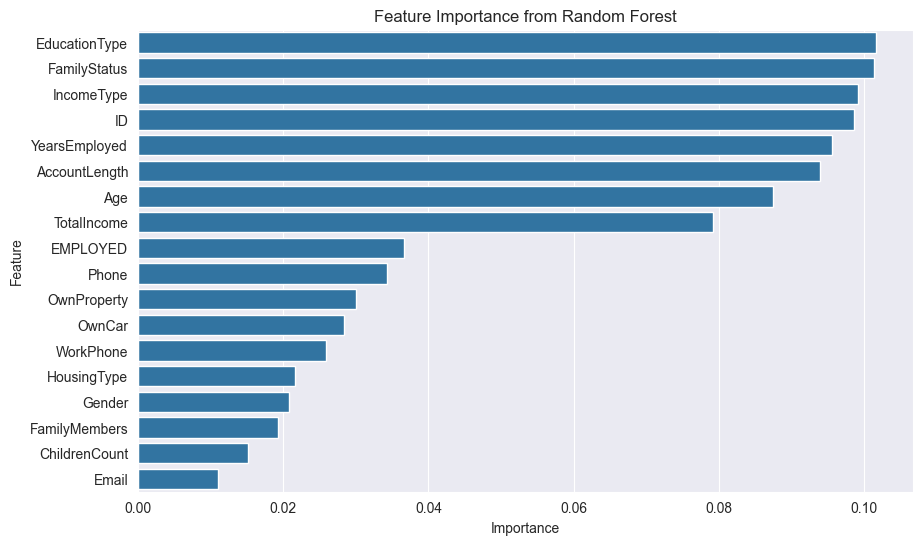

In [15]:
import numpy as np

plt.figure(figsize=(10, 6))
feature_importance = grid.best_estimator_.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]
sns.barplot(x=feature_importance[sorted_idx], y=X.columns[sorted_idx])
plt.title("Feature Importance from Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

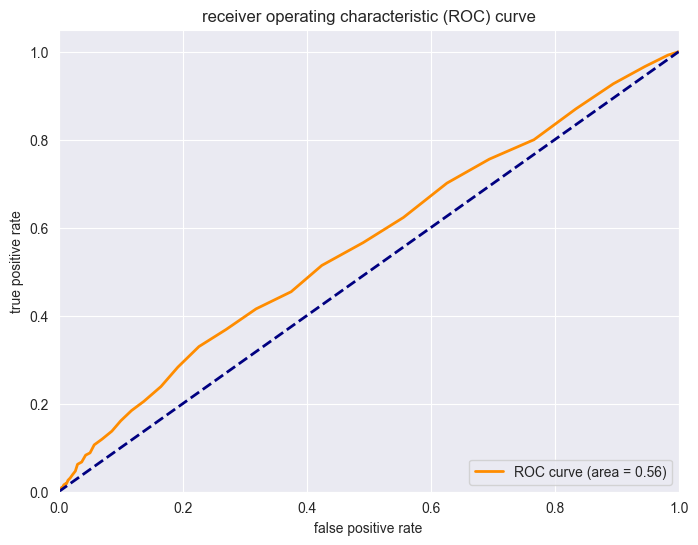

In [16]:
from sklearn.metrics import roc_curve, auc

y_pred_proba = grid.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()